# Raspberry Turk Robotic Arm

## Introduction

The Raspberry Turk uses a robotic arm ([SCARA](https://en.wikipedia.org/wiki/SCARA)) to pick up and move chess pieces. The arm consists of two links, whose rotation is each controlled by a separate servo. This allows it to move freely in the X-Y direction while remaining rigid in the Z direction. There is a third servo that controls the vertical motion at the end of the arm.

![](assets/realarm.png)

In order to move pieces, the robot needs to be able to adjust the servos rotation $(s_1, s_2)$ to accurately move the arm to any given $x, y$ coordinate on the board.

$s_1, s_2 = g(x, y)$

**Our goal in this notebook is to create this function $g(x, y)$.**

## Working Backwards

We'll eventualy get to $g(x, y)$, but to get there we need to work backwards. To begin, let's first formalize what we know.

![](assets/slice1.png)

The arm consists of two links of length $l_i$. Since we know the lengths of the links, we can come up with an equation to determine $x, y$ given their angles $(\theta_i)$.

$$f_x(\theta_1, \theta_2) = x_{offset} + cos(\theta_1) \cdot l_1 + cos(\theta_1 + \theta_2) \cdot l_2$$
$$f_y(\theta_1, \theta_2) = y_{offset} + sin(\theta_1) \cdot l_1 + sin(\theta_1 + \theta_2) \cdot l_2$$

Now, in order to derive $\theta_i$ we need to learn more about the servo and how it's attached to the arm.

![](assets/dx_series_goal.png)
<center>[_Diagram from Robotis Dynamixel AX-12A support manual_](http://support.robotis.com/en/product/dynamixel/ax_series/dxl_ax_actuator.htm#Actuator_Address_1E)</center>

You can adjust the rotation of the servo by setting the goal position address in the RAM of the servo. The goal position address is a number between 0 and 1023 (10 bit value) that maps to a 0° to 300° rotation. This equates to an accuracy of 0.29° per unit change in value (not bad!).

![](assets/servo.jpg)

The servo is attached to a pinion gear which rotates a larger gear that the link of the arm is directly attached to. The pinion gear has 32 teeth and the larger gear has 76 teeth. This gives us a gear ratio of $\frac{76}{32}$ or $2.375 : 1$. From now on we'll refer to this gear ratio as $\phi$. Additionally, we must account of the rotational offset of the link when the servo goal position has a value of $0$. We'll call this rotational offset $\theta'_i$. Given this, we can how calculate $\theta_i$ given the goal position ($s_i$) of the servo.

$$\theta_i(s_i) = \theta'_i + \frac{1023-s_i}{1023}\cdot 300°\cdot \phi$$

Now, we have everything we need to convert any $s_1, s_2$ to an $x, y$.

$$f_x(s_1, s_2) = x_{offset} + \cos(\frac{1023-s_1}{1023}\cdot 300°\cdot \phi + \theta'_1)\cdot l_1 + \cos((\frac{1023-s_1}{1023}\cdot 300°\cdot \phi + \theta'_1) + (\frac{1023-s_2}{1023}\cdot 300°\cdot \phi + \theta'_2)) \cdot l_2 \\[10pt]$$
$$f_y(s_1, s_2) = y_{offset} + \sin(\frac{1023-s_1}{1023}\cdot 300°\cdot \phi + \theta'_{s_1})\cdot l_1 + \sin((\frac{1023-s_1}{1023}\cdot 300°\cdot \phi + \theta'_1) + (\frac{1023-s_2}{1023}\cdot 300°\cdot \phi + \theta'_2)) \cdot l_2$$

However, both $f_x$ and $f_y$ are assuming ideal conditions. In reality there is error introduced by inaccuracies in measurements, and unaccounted for real world effects on the system. In order to achieve better accuracy in reality we need to better understand this error component and account for it.

$$f'_x(s_1, s_2) = f_x(s_1, s_2) + \epsilon_x(s_1, s_2)$$
$$f'_y(s_1, s_2) = f_y(s_1, s_2) + \epsilon_y(s_1, s_2)$$

$f'_x$ and $f'_y$ represent the actual real world $x, y$ given any $s_1, s_2$, where $\epsilon_x$ and $\epsilon_y$ is the respective error. In a more simple form:

$$f'(s) = f(s) + \epsilon(s)$$

To achieve a $f'(s)$ that is suffienct for our purposes we need to, as accurately as possible, model $\epsilon$.

## Data

In order to model $\epsilon$ we first need to collect a sample of data points. To do this I manually moved the arm to to 81 points and recorded the real $x, y$ and the respective $s_1, s_2$.

In [1]:
import project
import numpy as np
import pandas as pd

data = pd.read_csv(project.path('data', 'raw', 'arm_error.csv'))

In [2]:
data.head()

,s1,s2,x,y
0,92,482,0.125,0.0000
1,177,1023,0.000,18.0000
2,497,386,9.000,9.0000
3,950,0,18.000,0.1875
4,674,660,18.000,18.0000


We need two new columns for $x$ and $y$ error. We can calculate this by first calulating the theoretical coordinate and then subtracting the observed coordinate.

In [3]:
dynamixel_range = 300.0
gear_ratio = 76.0 / 32.0
l_1 = 15.25
l_2 = 13.75
x_offset = 17.0
y_offset = -2.97
gripper_offset = 0.5

def f_with_theta(s, theta_prime_1, theta_prime_2):
    theta_1 = ((1023.0-s[:,0])/1023.0) * np.deg2rad(dynamixel_range / gear_ratio) + theta_prime_1
    theta_2 = ((1023.0-s[:,1])/1023.0) * np.deg2rad(dynamixel_range / gear_ratio) + theta_prime_2
    x = x_offset + np.cos(theta_1) * l_1 + np.cos(theta_1 + theta_2) * l_2 + np.cos(theta_1 + theta_2 + np.pi/2.0) * gripper_offset
    y = y_offset + np.sin(theta_1) * l_1 + np.sin(theta_1 + theta_2) * l_2 + np.sin(theta_1 + theta_2 + np.pi/2.0) * gripper_offset
    return np.array([x, y]).T

## Optimization of Theta Values

$\theta'_1$ and $\theta'_2$ were measured by hand to be 4° and 40° respectively. To find a more accurate measurement, we will brute force values close to those and find the two values that results in the smallest mean squared error when comparing the theoretical results to the known values in the dataset. This will provide a better starting point when solving for $\epsilon$.

In [4]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import brute

def mse(theta):
    xy = f_with_theta(data.values[:,0:2], theta[0], theta[1])
    return np.array([mean_squared_error(data.x, xy[:,0]), mean_squared_error(data.y, xy[:,1])]).mean()

theta_prime_1_estimate = np.deg2rad(4.0)
theta_prime_2_estimate = np.deg2rad(40.0)

def slice_for_value(value):
    inc = value * 0.2
    return slice(value - inc, value + inc)

t = brute(mse, [slice_for_value(theta_prime_1_estimate),
                slice_for_value(theta_prime_2_estimate)])


print "θ′: {}".format(np.rad2deg(t))

θ′: [  3.82714566  39.9262376 ]


In [5]:
def f(s):
    return f_with_theta(s, t[0], t[1])

In [6]:
theoretical_xy = f(data.values[:,0:2])
data["x_theory"] = theoretical_xy[:,0]
data["y_theory"] = theoretical_xy[:,1]
data["x_error"] = data.x - data.x_theory
data["y_error"] = data.y - data.y_theory

In [7]:
data.head()

,s1,s2,x,y,x_theory,y_theory,x_error,y_error
0,92,482,0.125,0.0000,0.378050,0.236596,-0.253050,-0.236596
1,177,1023,0.000,18.0000,0.263558,18.327552,-0.263558,-0.327552
2,497,386,9.000,9.0000,8.948043,8.989270,0.051957,0.010730
3,950,0,18.000,0.1875,18.112372,0.139365,-0.112372,0.048135
4,674,660,18.000,18.0000,17.901277,18.107595,0.098723,-0.107595


## Visualizing Error

Below is a visualization of the error. The x and y axis on the graph represent inches from the bottom left corner of the chessboard. The actual $x,y$ is in blue, and the theoretical values are red. The equation is pretty accurate, but in the far corners, there is noticable error.

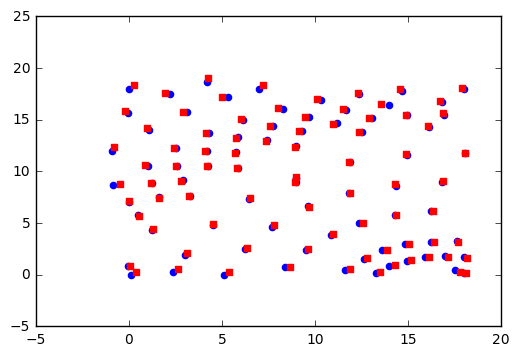

In [8]:
import matplotlib.pyplot as plt

def scatter(x, y):
    plt.scatter(data.x, data.y, color='blue')
    plt.scatter(x, y, color='red', marker=',')
    plt.show()

scatter(data.x_theory, data.y_theory)

Below is another way to visualize the error. This time the x and y axes represent servo values.

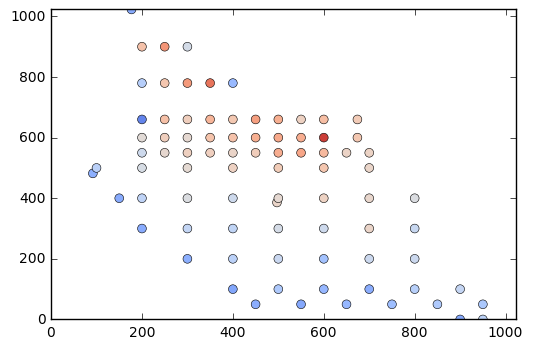

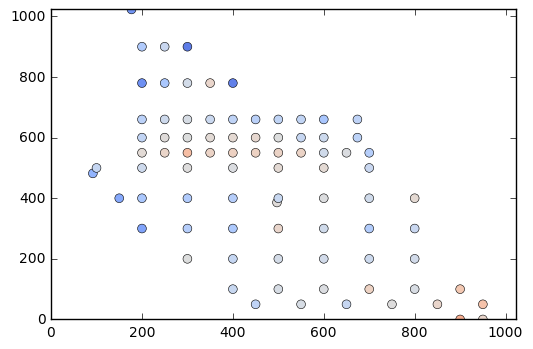

In [9]:
from matplotlib import cm
from matplotlib.colors import Normalize

plt.scatter(data.s1, data.s2, c=data.x_error, cmap=cm.coolwarm, norm=Normalize(-0.5, 0.5), linewidth=0.4, s=40.0)
plt.xlim(0,1023)
plt.ylim(0,1023)
plt.show()
plt.scatter(data.s1, data.s2, c=data.y_error, cmap=cm.coolwarm, norm=Normalize(-0.5, 0.5), linewidth=0.4, s=40.0)
plt.xlim(0,1023)
plt.ylim(0,1023)
plt.show()

## Model

The model is a simple polynomial regression.

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

S_train = data.values[:,0:2]
z_train = data.values[:,6:8]
poly = PolynomialFeatures(degree=3)
x_error_model = Pipeline([('poly', poly), ('linear', LinearRegression(normalize=True))])
y_error_model = Pipeline([('poly', poly), ('linear', LinearRegression(normalize=True))])

cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
cvs_x = cross_val_score(x_error_model, S_train, y=z_train[:, 0], scoring='neg_mean_squared_error', cv=cv)
cvs_y = cross_val_score(y_error_model, S_train, y=z_train[:, 1], scoring='neg_mean_squared_error', cv=cv)
print "Cross validation error for x: {}".format(cvs_x)
print "Cross validation error for y: {}".format(cvs_y)

x_error_model.fit(S_train, z_train[:, 0])
y_error_model.fit(S_train, z_train[:, 1])

def predict_error(s):
    return np.array([x_error_model.predict(s), y_error_model.predict(s)]).T

Cross validation error for x: [-0.01337804 -0.01384453 -0.00966184]
Cross validation error for y: [-0.00928625 -0.0084753  -0.0051186 ]


Below is a plot of the `predict_error` function with the real error plotted in circles on top.

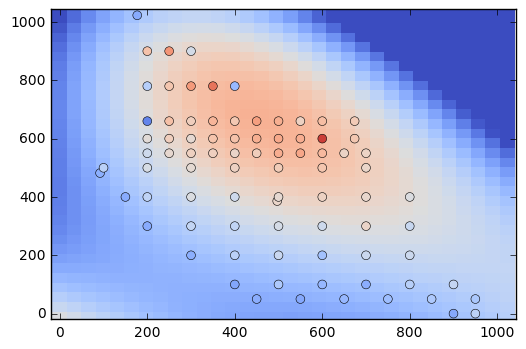

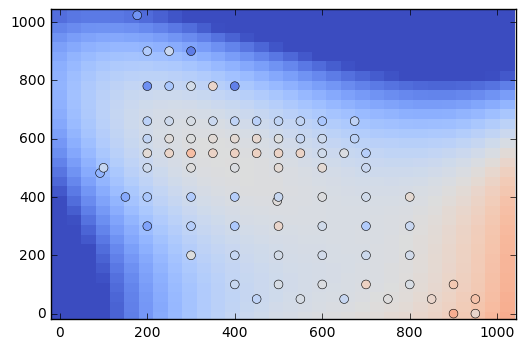

In [11]:
from itertools import product

s_plot = np.array(list(product(np.linspace(0.0, 1023.0, 32), np.linspace(0.0, 1023.0, 32))))
predicted_error = predict_error(s_plot)
x_error_predicted = predicted_error[:,0]
y_error_predicted = predicted_error[:,1]

plt.scatter(s_plot[:,0], s_plot[:,1], c=x_error_predicted, marker=',', cmap=cm.coolwarm, norm=Normalize(-0.5, 0.5), linewidth=0.0, s=120.0)
plt.scatter(data.s1, data.s2, c=data.x_error, cmap=cm.coolwarm, norm=Normalize(-0.5, 0.5), linewidth=0.4, s=40.0)
plt.xlim(-20,1043)
plt.ylim(-20,1043)
plt.show()

plt.scatter(s_plot[:,0], s_plot[:,1], c=y_error_predicted, marker=',',cmap=cm.coolwarm, norm=Normalize(-0.5, 0.5), linewidth=0.0, s=120.0)
plt.scatter(data.s1, data.s2, c=data.y_error, cmap=cm.coolwarm, norm=Normalize(-0.5, 0.5), linewidth=0.4, s=40.0)
plt.xlim(-20,1043)
plt.ylim(-20,1043)
plt.show()

## Building the Final Equation

Using the `predict_error` function $f'(s)$ can now be created,.

In [12]:
def f_prime(s):
    return f(s) + predict_error(s)

To visualize the difference $f'(s)$ makes, we can, once again, plot the predicted $x,y$ (red) on top of the real $x,y$ (blue) for each given $s_1,s_2$.

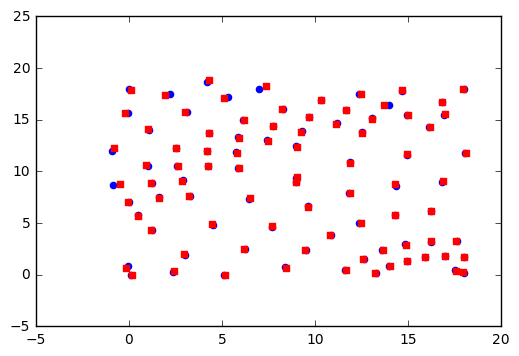

In [13]:
xy_theoretical_with_error = f_prime(data.values[:,0:2])
data['x_theory_with_error'] = xy_theoretical_with_error[:,0]
data['y_theory_with_error'] = xy_theoretical_with_error[:,1]

scatter(data.x_theory_with_error, data.y_theory_with_error)

Now that we have a working $f'(s)$, we can set out to accomplish our original goal, to create $g(x, y)$. The function $f'$ takes a $s_1, s_2$ and returns $x, y$. The function $g$ takes $x, y$ and returns $s_1, s_2$. In order to find $g$, we just need to invert $f'$! But $f'$ doesn't invert easily and we actually don't need $g$ to work over all values of $s_1,s_2$–only when $s_1,s_2 \in \{0, 1, 2, ..., 1023\}$. So instead, let's solve for every possible $s_1,s_2$ combination, and then create a [lookup tree](https://en.wikipedia.org/wiki/K-d_tree) with the results. We can the query the lookup tree to find the closest $s_1,s_2$ for any given point $x,y$.

In [14]:
srange = np.array(list(product(range(1024), range(1024))))
pts = f_prime(srange)

In [15]:
from sklearn.neighbors import KDTree
tree = KDTree(pts, metric='euclidean')

In [16]:
def g(pts):
    return np.array(srange[tree.query(pts, return_distance=False)]).reshape(-1,2)

## Visualizing the Final Equation

Below are two plots visualizing the function $g(x,y)$ over the entire 18"x18" chessboard. The first plot is $s_1$ and the second is $s_2$.

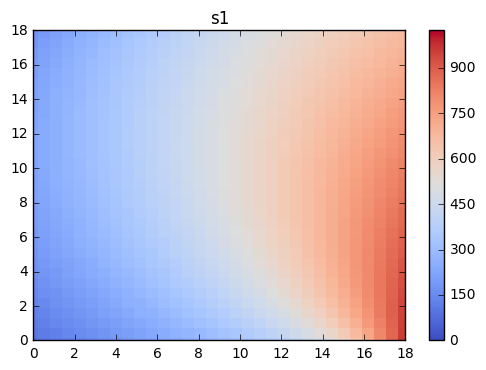

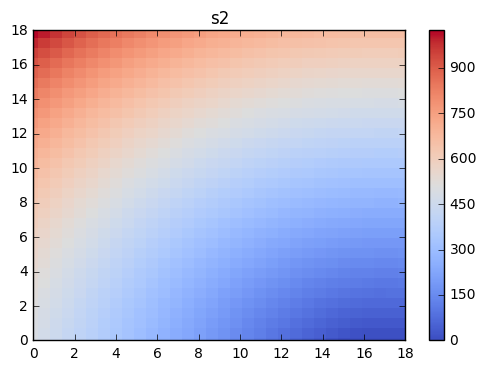

In [17]:
pts_grid = np.array(list(product(np.linspace(0.0, 18.0, 32), np.linspace(0.0, 18.0, 32))))
projected_s = g(pts_grid)

plt.scatter(pts_grid[:,0], pts_grid[:,1], c=projected_s[:,0], marker=',', cmap=cm.coolwarm, norm=Normalize(0, 1023), linewidth=0.0, s=120.0)
plt.xlim(0,18)
plt.ylim(0,18)
plt.colorbar()
plt.title("s1")
plt.show()

plt.scatter(pts_grid[:,0], pts_grid[:,1], c=projected_s[:,1], marker=',', cmap=cm.coolwarm, norm=Normalize(0, 1023), linewidth=0.0, s=120.0)
plt.xlim(0,18)
plt.ylim(0,18)
plt.colorbar()
plt.title("s2")
plt.show()

## Saving the Model

The $x,y$ associated with the each $s_1,s_2$ from 0 to 1023 is saved to disk so the lookup tree can be created on demand for the Raspberry Turk to use.

In [18]:
path = project.path('data', 'processed', 'arm_movement_engine_pts.npy')
with open(path, 'w') as f:
    np.save(f, pts)